In [1]:
%pip install pandas
%pip install tensorflow
%pip install matplotlib
%pip install numpy
%pip install scikit-learn
%pip install seaborn
%pip install tensorflow-gan
%pip install tqdm


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import tensorflow as tf
import os
from glob import glob

seed = 111

np.random.seed(seed)
tf.random.set_seed(seed)

# Data paths
DATA_DIR = "data"
MONET_DIR = os.path.join(DATA_DIR, "monet_jpg")
PHOTO_DIR = os.path.join(DATA_DIR, "photo_jpg")

# Load image paths
monet_paths = sorted(glob(os.path.join(MONET_DIR, "*.jpg")))
photo_paths = sorted(glob(os.path.join(PHOTO_DIR, "*.jpg")))

print(f"Monet images: {len(monet_paths)}")
print(f"Photo images: {len(photo_paths)}")

/Users/mikebrozowski/monet-gan/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Monet images: 300
Photo images: 7038


## Problem Description

This project is a submission for the Kaggle competition: https://www.kaggle.com/competitions/gan-getting-started

In this project, I explore the use of Generative Adversarial Networks (GANs) to translate real-world photographs into artistic paintings in the style of Monet. This task is a form of image-to-image translation, where the goal is to learn a mapping from one format (photos) to another (Monet-style paintings) using deep learning.

The core objective is to train a model that takes a natural photo as input and outputs a generated image that mimics the Monet painting style. This is a typical application of CycleGANs, which are designed to work with unpaired datasets — meaning we do not have exact photo-painting pairs.


## Dataset Description

The dataset consists of two unpaired image domains:

- **data/monet_jpg/**: Contains 300 JPG images of paintings by Claude Monet.
- **data/photo_jpg/**: Contains 7038 JPG images of real-world landscape photographs.

There is no one-to-one mapping between Monet images and photos. Instead, the model must learn to capture the distribution of Monet-style images and use it to transform photo images accordingly.

All images are RGB and vary in content but generally depict similar scenery: landscapes, nature, and outdoor settings — making them well-suited for style transfer.


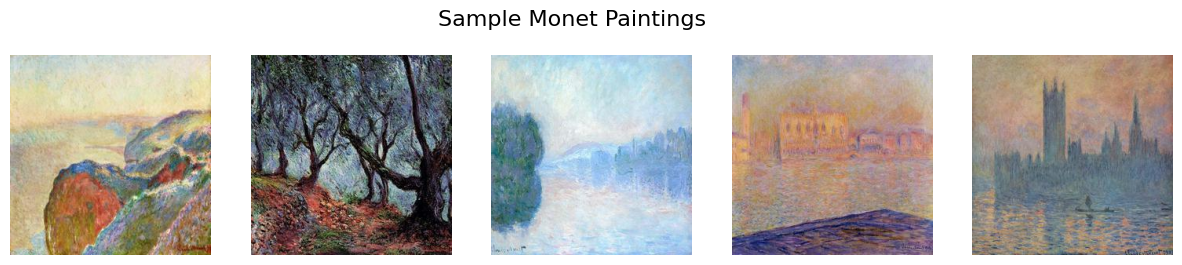

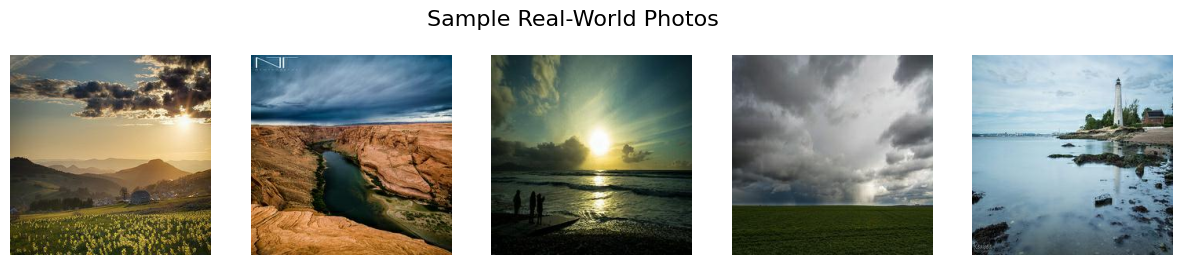

In [3]:
import matplotlib.pyplot as plt
from PIL import Image

def show_images(image_paths, title, n=5):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        img = Image.open(image_paths[i])
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

# Show sample Monet paintings
show_images(monet_paths, "Sample Monet Paintings")

# Show sample real-world photos
show_images(photo_paths, "Sample Real-World Photos")


## Strategy Based on EDA

EDA confirms the formats are similar in content but different in style. The lack of paired images makes CycleGAN my desired approach.

The plan:
1. Preprocess and normalize the images.
2. Train and compare three CycleGAN variants:
   - Baseline (9-block ResNet with partial InstanceNorm)
   - Full InstanceNorm CycleGAN
   - Lightweight (6-block ResNet) CycleGAN
3. Evaluate generated Monet-style images qualitatively and quantitatively.
4. Select the best model and tune hyperparameters such as learning rate, loss weights, and number of ResNet blocks.

In [4]:
import tensorflow as tf

# Constants
IMG_SIZE = 256
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

def load_and_preprocess_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

def build_dataset(image_paths, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(image_paths)
    ds = ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(image_paths))
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

# Build datasets
photo_ds = build_dataset(photo_paths)
monet_ds = build_dataset(monet_paths)


## Comparison of Architectures and Hyperparameters

To identify the most effective architecture for photo-to-Monet translation, we train and evaluate the following models:

### Architecture Variants

1. **Baseline CycleGAN**  
   - 9 ResNet blocks  
   - Instance normalization only in residual layers  
   - Serves as a control model

2. **CycleGAN with Full Instance Normalization**  
   - Applies InstanceNorm in all layers, including initial and final layers  
   - Expected to better capture artistic style and improve training stability

3. **Lightweight CycleGAN**  
   - 6 ResNet blocks instead of 9  
   - Reduces training time and model complexity  
   - Tests whether a lighter model can maintain quality

### Hyperparameter Tuning

Once the best architecture is chosen, we tune:

- **Learning Rate**: Tested values include `2e-4`, `1e-4`, and `5e-5`  
- **Cycle vs Identity Loss Weights**: Varying the contribution of cycle and identity loss terms  
- **Number of Residual Blocks**: Experimenting with `6`, `7`, and `9` blocks

We evaluate results using:
- Visual inspection of generated images
- Training stability and loss curves
- Using a CNN model to predict whether an image is generated or originally a Monet image, using accuracy as the metric

These experiments help determine which model and configuration best capture Monet’s style without distorting content.


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.initializers import Ones, Zeros

class InstanceNormalization(Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon
        self.gamma_initializer = Ones()
        self.beta_initializer = Zeros()

    def build(self, input_shape):
        channels = input_shape[-1]
        self.gamma = self.add_weight(
            shape=(channels,),
            name='gamma',
            initializer=self.gamma_initializer,
            trainable=True
        )
        self.beta = self.add_weight(
            shape=(channels,),
            name='beta',
            initializer=self.beta_initializer,
            trainable=True
        )

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (inputs - mean) * inv
        return self.gamma[None, None, None, :] * normalized + self.beta[None, None, None, :]


In [6]:
from tensorflow.keras import layers

def resnet_block(x, filters, norm_layer):
    shortcut = x
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = norm_layer()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = norm_layer()(x)
    return layers.add([x, shortcut])


In [7]:
from tensorflow.keras import models

def build_generator(img_shape=(256, 256, 3), n_blocks=9, norm_layer=InstanceNormalization):
    inputs = layers.Input(shape=img_shape)

    x = layers.Conv2D(64, 7, padding='same')(inputs)
    x = norm_layer()(x)
    x = layers.Activation('relu')(x)

    for f in [128, 256]:
        x = layers.Conv2D(f, 3, strides=2, padding='same')(x)
        x = norm_layer()(x)
        x = layers.Activation('relu')(x)

    for _ in range(n_blocks):
        x = resnet_block(x, 256, norm_layer)

    for f in [128, 64]:
        x = layers.Conv2DTranspose(f, 3, strides=2, padding='same')(x)
        x = norm_layer()(x)
        x = layers.Activation('relu')(x)

    x = layers.Conv2D(3, 7, padding='same', activation='tanh')(x)
    return models.Model(inputs, x)


In [8]:
def build_discriminator(img_shape=(256, 256, 3)):
    inputs = layers.Input(shape=img_shape)
    x = layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(0.2)(x)

    for f in [128, 256, 512]:
        x = layers.Conv2D(f, 4, strides=2, padding='same')(x)
        x = InstanceNormalization()(x)
        x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(1, 4, padding='same')(x)
    return models.Model(inputs, x)


In [9]:
class CycleGANTrainer(tf.Module):
    def __init__(self, G, F, DX, DY, g_opt, f_opt, dx_opt, dy_opt, lambda_cycle=10):
        super().__init__()
        self.G = G
        self.F = F
        self.DX = DX
        self.DY = DY
        self.g_opt = g_opt
        self.f_opt = f_opt
        self.dx_opt = dx_opt
        self.dy_opt = dy_opt
        self.lambda_cycle = lambda_cycle

        self.loss_obj = tf.keras.losses.MeanSquaredError()

    def discriminator_loss(self, real, fake):
        real_loss = self.loss_obj(tf.ones_like(real), real)
        fake_loss = self.loss_obj(tf.zeros_like(fake), fake)
        return (real_loss + fake_loss) * 0.5

    def generator_loss(self, fake):
        return self.loss_obj(tf.ones_like(fake), fake)

    def cycle_loss(self, real, cycled):
        return tf.reduce_mean(tf.abs(real - cycled))

    @tf.function
    def __call__(self, real_x, real_y):
        with tf.GradientTape(persistent=True) as tape:
            fake_y = self.G(real_x, training=True)
            cycled_x = self.F(fake_y, training=True)

            fake_x = self.F(real_y, training=True)
            cycled_y = self.G(fake_x, training=True)

            same_x = self.F(real_x, training=True)
            same_y = self.G(real_y, training=True)

            dx_real = self.DX(real_x, training=True)
            dx_fake = self.DX(fake_x, training=True)

            dy_real = self.DY(real_y, training=True)
            dy_fake = self.DY(fake_y, training=True)

            g_loss = self.generator_loss(dy_fake)
            f_loss = self.generator_loss(dx_fake)

            total_cycle_loss = self.cycle_loss(real_x, cycled_x) + self.cycle_loss(real_y, cycled_y)
            total_cycle_loss *= self.lambda_cycle

            g_loss += total_cycle_loss + self.cycle_loss(real_y, same_y) * 0.5
            f_loss += total_cycle_loss + self.cycle_loss(real_x, same_x) * 0.5

            dx_loss = self.discriminator_loss(dx_real, dx_fake)
            dy_loss = self.discriminator_loss(dy_real, dy_fake)

        g_grads = tape.gradient(g_loss, self.G.trainable_variables)
        f_grads = tape.gradient(f_loss, self.F.trainable_variables)
        dx_grads = tape.gradient(dx_loss, self.DX.trainable_variables)
        dy_grads = tape.gradient(dy_loss, self.DY.trainable_variables)

        self.g_opt.apply_gradients(zip(g_grads, self.G.trainable_variables))
        self.f_opt.apply_gradients(zip(f_grads, self.F.trainable_variables))
        self.dx_opt.apply_gradients(zip(dx_grads, self.DX.trainable_variables))
        self.dy_opt.apply_gradients(zip(dy_grads, self.DY.trainable_variables))

    def train(self, photo_ds, monet_ds, epochs):
        photo_iter = iter(photo_ds)
        monet_iter = iter(monet_ds)

        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")
            for _ in range(min(len(photo_ds), len(monet_ds))):
                real_x = next(photo_iter)
                real_y = next(monet_iter)
                self(real_x, real_y)


In [10]:
loss_fn = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real, fake):
    real_loss = loss_fn(tf.ones_like(real), real)
    fake_loss = loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

def generator_loss(fake):
    return loss_fn(tf.ones_like(fake), fake)

def cycle_consistency_loss(real, cycled, lamb=10):
    return lamb * tf.reduce_mean(tf.abs(real - cycled))

def identity_loss(real, same, lamb=5):
    return lamb * tf.reduce_mean(tf.abs(real - same))


In [11]:
g_opt_base = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
f_opt_base = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
dx_opt_base = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
dy_opt_base = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [12]:
G_base = build_generator(n_blocks=9)
F_base = build_generator(n_blocks=9)
DX_base = build_discriminator()
DY_base = build_discriminator()

trainer_base = CycleGANTrainer(G_base, F_base, DX_base, DY_base, g_opt_base, f_opt_base, dx_opt_base, dy_opt_base)
trainer_base.train(photo_ds, monet_ds, epochs=1)


Epoch 1/1


In [13]:
from PIL import Image
import os

def denormalize_img(tensor):
    tensor = (tensor + 1.0) * 127.5
    return tf.cast(tf.clip_by_value(tensor, 0, 255), tf.uint8)

def save_image_batch(batch_tensor, filenames, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for img, name in zip(batch_tensor, filenames):
        img = denormalize_img(img).numpy()
        img = Image.fromarray(img)
        img.save(os.path.join(output_dir, name))


In [14]:
# Get a batch of real photos
sample_batch = next(iter(photo_ds))
output_batch = G_base(sample_batch, training=False)

# Generate filenames like: photo_0001.jpg, photo_0002.jpg, ...
filenames = [f"photo_{i:04d}.jpg" for i in range(len(output_batch))]

# Save to directory
save_image_batch(output_batch, filenames, output_dir="outputs/baseline")


In [15]:
# Build
G_full = build_generator(n_blocks=9, norm_layer=InstanceNormalization)
F_full = build_generator(n_blocks=9, norm_layer=InstanceNormalization)
DX_full = build_discriminator()
DY_full = build_discriminator()

# new optimizers (fresh set for each model)
g_opt_full = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
f_opt_full = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
dx_opt_full = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
dy_opt_full = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


# Train
trainer_full = CycleGANTrainer(G_full, F_full, DX_full, DY_full, g_opt_full, f_opt_full, dx_opt_full, dy_opt_full)
trainer_full.train(photo_ds, monet_ds, epochs=1)

# Generate samples
sample_batch = next(iter(photo_ds))
output_batch = G_full(sample_batch, training=False)
filenames = [f"photo_{i:04d}.jpg" for i in range(len(output_batch))]
save_image_batch(output_batch, filenames, output_dir="outputs/instancenorm")


Epoch 1/1


In [16]:
# Build
G_light = build_generator(n_blocks=6, norm_layer=InstanceNormalization)
F_light = build_generator(n_blocks=6, norm_layer=InstanceNormalization)
DX_light = build_discriminator()
DY_light = build_discriminator()

# new optimizers (fresh set for each model)
g_opt_light = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
f_opt_light = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
dx_opt_light = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
dy_opt_light = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


# Train
trainer_light = CycleGANTrainer(G_light, F_light, DX_light, DY_light, g_opt_light, f_opt_light, dx_opt_light, dy_opt_light)
trainer_light.train(photo_ds, monet_ds, epochs=1)


# Generate samples
sample_batch = next(iter(photo_ds))
output_batch = G_light(sample_batch, training=False)
filenames = [f"photo_{i:04d}.jpg" for i in range(len(output_batch))]
save_image_batch(output_batch, filenames, output_dir="outputs/lightweight")


Epoch 1/1


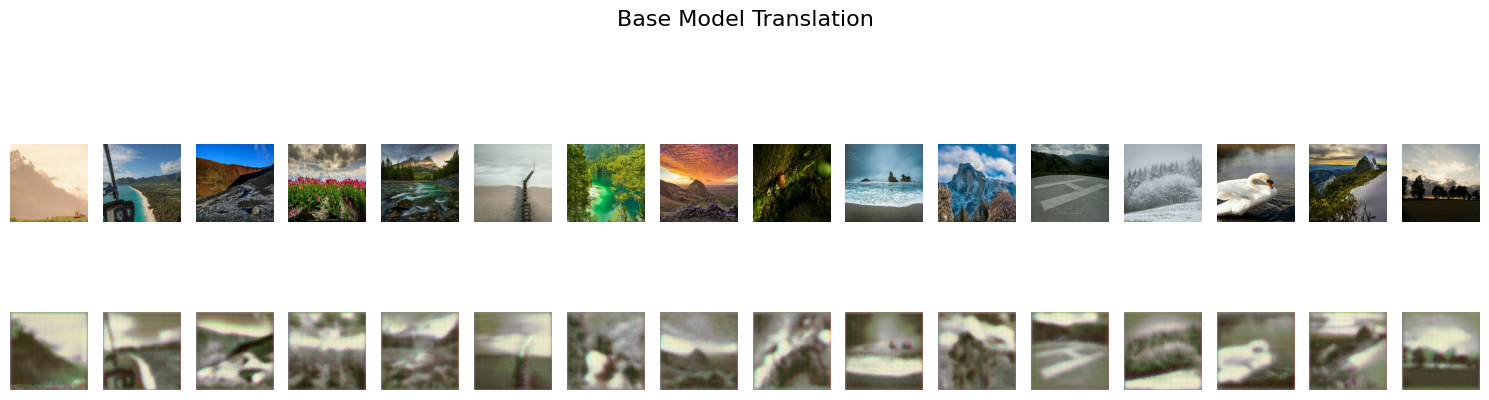

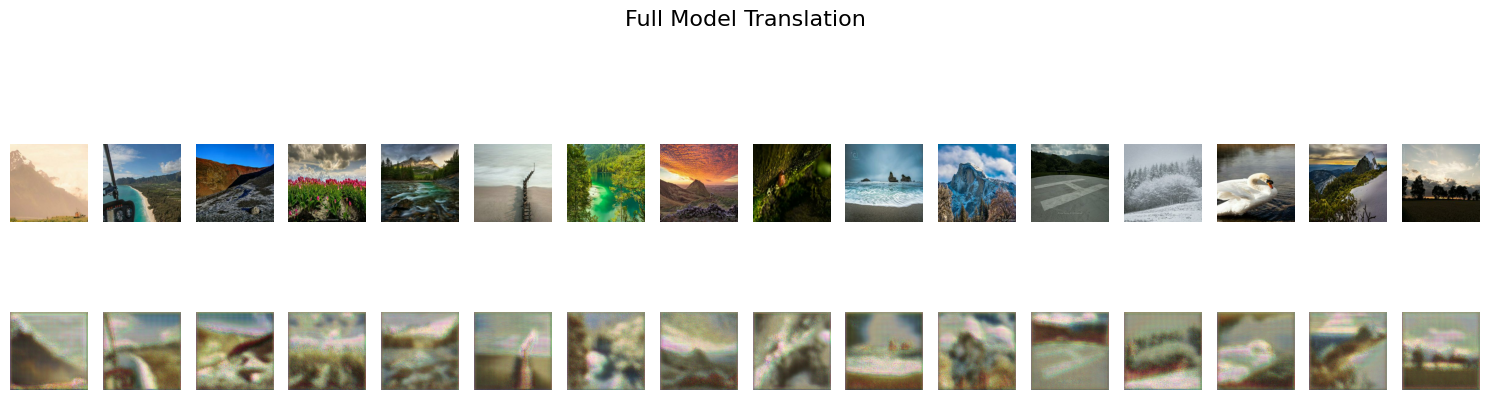

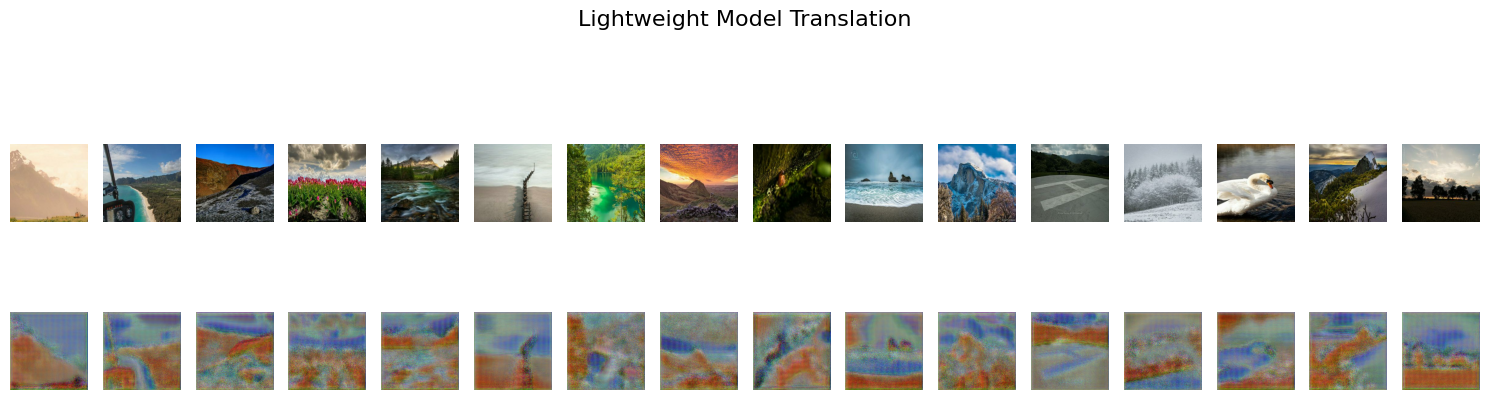

In [17]:
import matplotlib.pyplot as plt

def show_cycle_results(photo_batch, g_model, title):
    monet_batch = g_model(photo_batch, training=False)
    fig, axes = plt.subplots(2, len(photo_batch), figsize=(15, 5))
    for i in range(len(photo_batch)):
        axes[0, i].imshow((photo_batch[i].numpy() + 1) / 2)
        axes[0, i].axis('off')
        axes[1, i].imshow((monet_batch[i].numpy() + 1) / 2)
        axes[1, i].axis('off')
    axes[0, 0].set_ylabel("Input", fontsize=14)
    axes[1, 0].set_ylabel("Monet", fontsize=14)
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Restore dataset
photo_ds = build_dataset(photo_paths)

# Get a batch
sample_batch = next(iter(photo_ds))

# Visualize both models
show_cycle_results(sample_batch, G_base, "Base Model Translation")
show_cycle_results(sample_batch, G_full, "Full Model Translation")
show_cycle_results(sample_batch, G_light, "Lightweight Model Translation")


### Model Decision

It looks like the lightweight model was able to generate images without much difference compared to the base model or full model. Since it has a faster processing time, it looks like that is the best choice to generate the Monet-like images.

In [18]:
import os
from PIL import Image
import numpy as np

def save_images(model, dataset, out_dir, num_images=100):
    os.makedirs(out_dir, exist_ok=True)
    ds_list = list(dataset.unbatch().as_numpy_iterator())
    for i in range(num_images):
        image_index = np.random.randint(0, len(dataset))
        img = ds_list[image_index]
        img = tf.expand_dims(img, axis=0)
        gen_img = model(img, training=False)[0]
        gen_img = ((gen_img.numpy() + 1) * 127.5).astype("uint8")  # [-1,1] → [0,255]
        Image.fromarray(gen_img).save(os.path.join(out_dir, f"{i}.jpg"))


In [22]:
# Save generated Monet-style images and real Monet images
save_images(G_light, photo_ds, "fake_monet", num_images=300)


### Test Against a CNN

Now that the images have been generated, I'll put it to the test against a CNN model to determine its accuracy. This doesn't really help to train the GAN, but it is a way to continue to see if it creates images well enough that a simple CNN architecture can determine if a given image is from Monet or generated. I expect even a simple CNN to be able to differentiate the two labels with a high accuracy.

In [23]:
import tensorflow as tf
import os

def load_labeled_dataset(dir_path, label):
    files = tf.io.gfile.glob(os.path.join(dir_path, '*.jpg'))
    ds = tf.data.Dataset.from_tensor_slices(files)

    def _parse_image(file):
        img = tf.io.read_file(file)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [256, 256])
        img = img / 255.0
        return img, tf.constant(label, dtype=tf.float32)

    return ds.map(_parse_image)

real_ds = load_labeled_dataset("data/monet_jpg", 1).take(300)
fake_ds = load_labeled_dataset("fake_monet", 0).take(300)


In [24]:
dataset = real_ds.concatenate(fake_ds).shuffle(512).batch(32)

In [25]:
def build_binary_classifier():
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(256, 256, 3)),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])


In [26]:
clf = build_binary_classifier()
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
clf.fit(dataset, epochs=3)


Epoch 1/3
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 0.5509 - loss: 2.1954
Epoch 2/3
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.9336 - loss: 0.2030
Epoch 3/3
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.9875 - loss: 0.0266


In [27]:
import matplotlib.pyplot as plt

def show_predictions(model, dataset, num_images=10):
    for images, labels in dataset.take(1):
        preds = model.predict(images).flatten()
        plt.figure(figsize=(15, 6))
        for i in range(num_images):
            plt.subplot(2, 5, i + 1)
            plt.imshow(images[i])
            plt.title(f"{'Real' if preds[i] > 0.5 else 'Fake'}\nScore: {preds[i]:.2f}")
            plt.axis("off")
        plt.tight_layout()
        plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


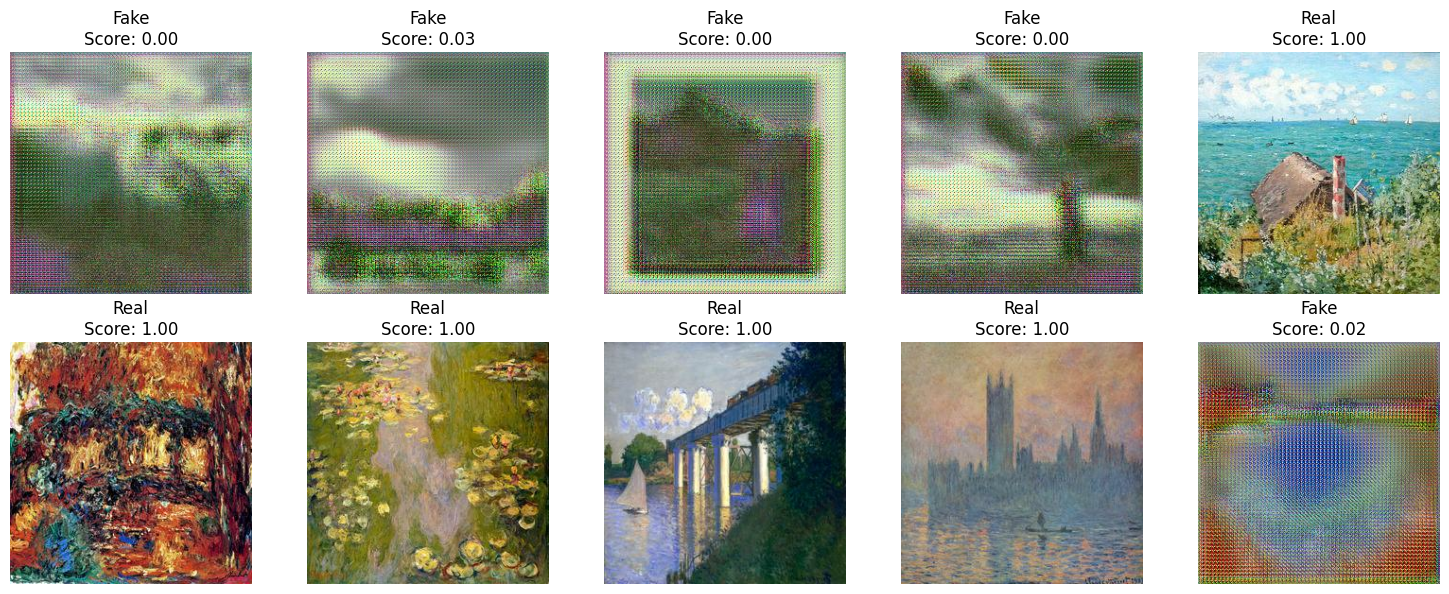

In [30]:
show_predictions(clf, dataset)


In [29]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# Get true labels and predicted probabilities
y_true = []
y_probs = []

for images, labels in dataset:
    preds = clf.predict(images).squeeze()
    y_probs.extend(preds)
    y_true.extend(labels.numpy())

# Convert to binary predictions
y_pred = (np.array(y_probs) > 0.5).astype(int)
y_true = np.array(y_true)

# Compute accuracy and confusion matrix
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {acc:.2%}")
print("Confusion Matrix:")
print(cm)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Accuracy: 99.50%
Confusion Matrix:
[[297   3]
 [  0 300]]


The following cell was used to generate the images and compress them into a zip file to submit into the Kaggle competition.

In [ ]:
# import os
# from tensorflow.keras.preprocessing import image
# from tqdm import tqdm
# import zipfile

# # 1. Load test photos
# test_folder = "fake_monet"  # folder of photos you need to translate
# test_paths = sorted([os.path.join(test_folder, fname)
#                      for fname in os.listdir(test_folder) if fname.endswith(".jpg")])

# # 2. Generate and save Monet-style images
# os.makedirs("generated_monet_test", exist_ok=True)
# for idx, img_path in enumerate(tqdm(test_paths)):
#     img = image.load_img(img_path, target_size=(256, 256))
#     arr = image.img_to_array(img) / 127.5 - 1
#     gen = G_full(tf.expand_dims(arr, 0), training=False)[0]
#     gen = (gen.numpy() * 127.5).astype("uint8")
#     fname = f"{os.path.splitext(os.path.basename(img_path))[0]}.jpg"
#     image.array_to_img(gen).save(os.path.join("generated_monet_test", fname))

# # 3. Create images.zip
# with zipfile.ZipFile("images.zip", "w") as z:
#     for fname in os.listdir("generated_monet_test"):
#         z.write(os.path.join("generated_monet_test", fname),
#                 arcname=fname)
